### Introduction
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://2.bp.blogspot.com/-UO8E6wws1Go/XGWgbLTPJnI/AAAAAAAABoQ/tGuBrjfJZ1UGmUQ112ZCv3gAu3Tg0O1FACLcBGAs/s1600/image001-min.png)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- the distribution of words for each topic K
- the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

### LDA Implementation

1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Preparing data for LDA analysis
5. Model Evaluation and parameter tuning

In [ ]:
!pip install textstat
# !pip install pyspellchecker
!apt-get install -y libhunspell-dev
!pip install hunspell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dictionaries-common hunspell-en-us libhunspell-1.7-0 libtext-iconv-perl
Suggested packages:
  ispell | aspell | hunspell wordlist hunspell openoffice.org-hunspell | openoffice.org-core
The following NEW packages will be installed:
  dictionaries-common hunspell-en-us libhunspell-1.7-0 libhunspell-dev libtext-iconv-perl
0 upgraded, 5 newly installed, 0 to remove and 35 not upgraded.
Need to get 896 kB of archives.
After this operation, 3,130 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libtext-iconv-perl amd64 1.7-7build3 [14.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 dictionaries-common all 1.28.14 [185 kB]


In [ ]:
# DOWNLOAD LEMMATISER DATA
# `nltk.download('punkt')` and `nltk.download('wordnet')` are used to download the necessary resources for tokenization and lemmatization.
# 1. `nltk.download('punkt')`: This downloads the Punkt tokenizer. This is a pre-trained unsupervised machine learning model for tokenizing text. It's used by `nltk.word_tokenize()` to split the input text into words and punctuation.
# 2. `nltk.download('wordnet')`: This downloads WordNet, a large lexical database of English. Nouns, verbs, adjectives, and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. The WordNetLemmatizer uses WordNet to look up lemmas, or root forms of words.
from google.colab import drive
import nltk

# Mount Google Drive
drive.mount('/content/drive/')

# Set NLTK data path to Google Drive
nltk.data.path.append("/content/drive/My Drive/SMU TMLP/nltk_data")

# Download NLTK data to Google Drive
nltk.download('punkt', download_dir="/content/drive/My Drive/SMU TMLP/nltk_data")
nltk.download('wordnet', download_dir="/content/drive/My Drive/SMU TMLP/nltk_data")

Mounted at /content/drive/


[nltk_data] Downloading package punkt to /content/drive/My Drive/SMU
[nltk_data]     TMLP/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /content/drive/My Drive/SMU
[nltk_data]     TMLP/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
drive.flush_and_unmount()

In [ ]:
# Reading the data from Google Drive

from google.colab import drive
import os

drive.mount('/content/drive/')

os.listdir('/content/drive/My Drive/SMU TMLP') # # list the contents of the directory

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['EDA.ipynb',
 'IS450 Text Mining LDA Modelling (Edited).zip',
 'enron clean.xlsx',
 'nltk_data',
 'enron_clean_reduced_temp_KHCWSMerge.csv',
 'LDA_TopicModeling_Enron Fraud FE + PCA (Copy Latest Colab WS).ipynb',
 'Merge Data',
 'Feature Correlation 2.ipynb',
 '.ipynb_checkpoints',
 'Word Docs',
 'enron_clean_V2.csv',
 'Kheng',
 'Joy',
 'Jeremy',
 'Mutual Information Feature Selection Copy.ipynb',
 'Random Forest WS.ipynb']

#### Data Cleaning Part 1

We realise that for Unique-Mails-From-Sender, if >= 5, Low-Comm = False. Think we can drop 'Low-Comm'

CC and BCC have alot of seemingly empty rows, however, upon checking with .info(), its not actually null but a ' ' whitespace

CC and BCC appear to show the same information, so think we drop CC in favour for the cleaner BCC

- Sender-Type encoded to 0 - internal (within enron), 1 - external
- Label golden truth for scams remains 0 - safe, 1 - scam
- Contains-Reply-Forward for False: 0, True: 1

In [ ]:
# import pandas as pd

# # File path to the CSV
# file_path = '/content/drive/MyDrive/IS450 Text Mining Collab/enron clean latest.csv'

# # Add any row numbers that have issues
# skip_rows = [16553]

# # Read the CSV file into a DataFrame, skip rows that encounter issues
# try:
#     dataframe = pd.concat(
#         pd.read_csv(file_path, encoding='utf-8', skiprows=skip_rows)
#     )

#     dataframe.describe(include='all')
# except Exception as e:
#     print("An error occurred:", e)

import pandas as pd
file_path = '/content/drive/My Drive/SMU TMLP/'
file_name = 'enron clean.xlsx'

# Read the CSV file into a DataFrame, skip rows that encounter issues
try :
    df = pd.read_excel(file_path + file_name)
    print('File read into a pandas DataFrame')
except Exception as e:
    print('Error reading file: ', e)

Error reading file:  [Errno 2] No such file or directory: '/content/drive/My Drive/SMU TMLP/enron clean.xlsx'


In [ ]:
# Set the maximum number of columns to display to None
pd.set_option('display.max_columns', None)

# Display the DataFrame in the Jupyter Notebook
display(df.head())
# print(df.iloc[16553])

NameError: name 'df' is not defined

In [ ]:
display(df[['Low-Comm','Unique-Mails-From-Sender']])

NameError: name 'df' is not defined

In [ ]:
# print(df[df['Bcc'].notna()][['Cc', 'Bcc']].info())
display(df['Bcc'].iloc[0])

# display rows where 'Bcc' is not empty and not just a whitespace
df[(df['Bcc'].str.strip() != '')][['Cc', 'Bcc']]

NameError: name 'df' is not defined

In [ ]:
# Remove the specified columns
columns_to_drop = ["Folder-User", "Folder-Name", "To", "Message-ID", "Mime-Version", "Content-Type",
                   "Content-Transfer-Encoding", 'X-From', 'X-To','X-cc', 'X-bcc', "X-Folder", "X-FileName", "Time", 'Low-Comm', 'Cc', 'Suspicious-Folders',
                   "Attendees", "Re", "Source", "Mail-ID", "POI-Present"]

df_red = df.drop(columns=columns_to_drop, errors="ignore")

# show df columns and length of column index
print(df.columns, df.columns.shape[0])
print(df_red.columns, df_red.columns.shape[0])
display(df_red.sample(5))


In [ ]:
# Convert the 'Label' column from string to numeric values
df_red['Label'] = pd.to_numeric(df_red['Label'])

from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder for each column
le_reply_forwards = LabelEncoder()
le_sender_type = LabelEncoder()

# fit and transform the columns
df_red['Contains-Reply-Forwards'] = le_reply_forwards.fit_transform(df_red['Contains-Reply-Forwards'])
df_red['Sender-Type'] = le_sender_type.fit_transform(df_red['Sender-Type'])
display(df_red.sample(5))

In [ ]:
# print the original labels and their encodings
for i, label in enumerate(le_reply_forwards.classes_):
    print(f"{label}: {i}")

In [ ]:
# save file
df_red.to_csv(file_path + 'enron clean reduced.csv', index=False)


#### Data Cleaning Part 2
**Date** convert to 'year', 'month', 'day', 'hour', and 'day_of_week'

Realised that date time contains different time zones (PDT and PST)


**Subject and Body**
- Number of words
- Number of sentences
- Median number of characters per word
- Median number of words per sentence
- Upper-case character ratio
- Punctuations ratio
- Typo ratio
- Special characters ratio

Using min-max scaler


**Body specifically**
- Sentiment + Emotional Intensity
VADER




**Unique-Mails-From-Sender (min-max scaling)**
Since the distribution of 'Unique-Mails-From-Sender' is unknown and potentially non-normal, it might be safer to use Min-Max scaling. This is because z-score normalization (or standard scaling) is less robust to outliers, and it assumes that the data follows a Gaussian distribution.






**yet to include**

**Frequency of POS tags**
**Frequency of Discourse markers**
- nouns, verbs, etc

**Median syntactic complexity of sentence**
- depth of parse tree
**Median lexical complexity of sentence**
- type-token ratio (TTR)
- len(set(tokens)) / len(tokens)
Text contextual based vectors using GloVe and/or Word2Vec

**Number of Bcc’ed**


min-max scaler


In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/SMU TMLP/'
file_name = 'enron clean reduced.csv'
# file_name = 'enron clean reduced temp.csv'

# Read the CSV file into a DataFrame, skip rows that encounter issues
try :
    df = pd.read_csv(file_path + file_name)
    print('File read into a pandas DataFrame')
except Exception as e:
    print('Error reading file: ', e)
display(df)

File read into a pandas DataFrame


,Date,From,Subject,X-Origin,Body,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label
0,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,,0,18,0,0
1,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,,0,4,0,0
2,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",,0,3,0,0
3,"Mon, 11 Dec 2000 23:52:00 -0800 (PST)",klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,,0,9,1,0
4,"Mon, 14 May 2001 23:59:00 -0700 (PDT)",soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,,0,352,0,0
...,...,...,...,...,...,...,...,...,...,...
433069,"Fri, 21 Sep 2001 11:48:44 -0700 (PDT)",bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,,1,7,0,0
433070,"Tue, 4 Sep 2001 08:40:08 -0700 (PDT)",sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,46,0,0
433071,"Mon, 5 Nov 2001 01:20:12 -0800 (PST)",ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",,1,64,0,0
433072,"Wed, 17 Oct 2001 16:02:14 -0700 (PDT)",cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,"frank.hayden@enron.com, ted.murphy@enron.com",1,67,0,0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# create new features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Day_of_week'] = df['Date'].dt.dayofweek

# rearrange the columns
cols = df.columns.tolist()
cols = cols[:cols.index('Date')+1] + cols[-5:] + cols[cols.index('Date')+1:-5]
df = df[cols]

df = df.drop(columns='Date', errors="ignore")
df

,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,,0,18,0,0
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,,0,4,0,0
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",,0,3,0,0
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,,0,9,1,0
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,,0,352,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,,1,7,0,0
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,46,0,0
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",,1,64,0,0
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,"frank.hayden@enron.com, ted.murphy@enron.com",1,67,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the 'Unique-Mails-From-Sender' column
df['Unique-Mails-From-Sender'] = scaler.fit_transform(df[['Unique-Mails-From-Sender']])

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['Body'].apply(lambda x: sia.polarity_scores(str(x)))
df['sentiment_score_compound'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_score_positive'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['pos'])
df['sentiment_score_neutral'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['neu'])
df['sentiment_score_negative'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['neg'])

cols = df.columns.tolist()
cols = cols[:cols.index('Body')+1] + cols[-5:] + cols[cols.index('Body')+1:-5]
df = df[cols]

df.drop(columns='sentiment_scores', errors='ignore', inplace=True)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-8-5b46456ea985>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='sentiment_scores', errors='ignore', inplace=True)


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# already downloaded at the start
# nltk.download('punkt')
# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatiser(text):
  if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
      return ''
  else:
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

df[['Subject_lemma', 'Body_lemma']] = df[['Subject', 'Body']].applymap(lemmatiser)

In [ ]:
# save file
df.to_csv(file_path + 'enron clean reduced temp.csv', index=False)

In [ ]:
# Display df
display(df)

,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,sentiment_score_compound,sentiment_score_positive,sentiment_score_neutral,sentiment_score_negative,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label,Subject_lemma,Body_lemma
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,0.9616,0.226,0.708,0.066,,0,0.003281,0,0,Status,Status John : I 'm not really sure what happen...
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,0.5940,0.074,0.926,0.000,,0,0.000729,0,0,re : summer inverse,re : summer inverse i suck-hope youve made mor...
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",-0.3923,0.036,0.918,0.045,,0,0.000547,0,0,The WTI Bullet swap contract,"The WTI Bullet swap contract Hi , Following th..."
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,-0.4767,0.000,0.829,0.171,,0,0.001641,1,0,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,Fwd : NYTimes.com Article : Suspended Rabbi Qu...
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,-0.0772,0.058,0.893,0.050,,0,0.064163,0,0,daily chart and matrix a hot link 5/15,daily chart and matrix a hot link 5/15 The inf...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,0.0000,0.000,1.000,0.000,,1,0.001276,0,0,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,Review Board Books w/Rebecca C./BillB/DaveG/Mi...
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,0.0000,0.000,1.000,0.000,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,0.008385,0,0,Audit Committee Materials meeting,Audit Committee Materials meeting Two meeting ...
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",0.9758,0.118,0.851,0.031,,1,0.011666,0,0,Credit Story,"Credit Story Rick/Bill/David , Generally , we ..."
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,0.9658,0.067,0.905,0.028,"frank.hayden@enron.com, ted.murphy@enron.com",1,0.012213,0,0,Commodity Group Limit Issue,Commodity Group Limit Issue In addition to the...


In [ ]:
# Error

import pandas as pd
import numpy as np
import textstat
from sklearn.preprocessing import MinMaxScaler
# from spellchecker import SpellChecker
import hunspell
import re

# function to calculate median number of characters per word
floats = []
temp = pd.DataFrame()
def median_chars_per_word(text):
    if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
        return 0
    else:
        words = text.split()
        if words:
            return np.median([len(word) for word in words])
        else:
            return 0

# function to calculate median number of words per sentence
def median_words_per_sentence(text):
  if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
      return 0
  else:
    sentences = textstat.sentence_count(text)
    if sentences:
        return textstat.lexicon_count(text, removepunct=True) / sentences
    else:
        return 0

# function to calculate upper-case character ratio
def uppercase_ratio(text):
  if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
      return 0
  else:
      return sum(1 for c in text if c.isupper()) / len(text)

# function to calculate punctuation ratio
def punctuation_ratio(text):
  if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
      return 0
  else:
      return sum(1 for c in text if c in string.punctuation) / len(text)

# function to calculate typo ratio per word
spell_checker = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')
def typo_ratio(text):
  if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
      return 0
  else:
    # spell = SpellChecker()
    # words = text.split()
    # misspelled = spell.unknown(words)
    # return len(misspelled) / len(words) if words else 0

    words = re.findall(r'\b\w+\b', text)
    misspelled = [word for word in words if not spell_checker.spell(word)]
    return len(misspelled) / len(words) if words else 0
# The `typo_ratio` function calculates the ratio of misspelled words to the total number of words in the given text. The text "daily charts and matrices as hot links 5/15" is split into words, and each word is checked against the Hunspell dictionary. If a word is not found in the dictionary, it is considered a typo.
# In this case, the word "5/15" is likely not found in the dictionary, as it's a date or a fraction, not a standard English word. Therefore, it's considered a typo by the function.
# The total number of words in the text is 9 ("daily", "charts", "and", "matrices", "as", "hot", "links", "5/15"). Since there's one typo ("5/15"), the typo ratio is 1/9 = 0.1111.
# This is a limitation of using a dictionary-based spell checker: it can only check if words are in the dictionary, not if they are used correctly in context. Also, it may not recognize domain-specific terms, abbreviations, or numbers as correctly spelled words.

# function to calculate special characters ratio
def special_chars_ratio(text):
  if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
    return 0
  else:
    return sum(1 for c in text if not c.isalnum() and not c.isspace()) / len(text)

# apply the functions to the 'Subject' and 'Body' columns
for col in ['Subject', 'Body']:
    df[col + '_num_words'] = df[col].apply(textstat.lexicon_count, removepunct=True)
    df[col + '_num_sentences'] = df[col].apply(textstat.sentence_count)
    df[col + '_num_bcc'] = df[col].apply()
    df[col + '_median_chars_per_word'] = df[col].apply(median_chars_per_word)
    df[col + '_median_words_per_sentence'] = df[col].apply(median_words_per_sentence)
    df[col + '_uppercase_ratio'] = df[col].apply(uppercase_ratio)
    df[col + '_punctuation_ratio'] = df[col].apply(punctuation_ratio)
    df[col + '_typo_ratio'] = df[col].apply(typo_ratio)
    df[col + '_special_chars_ratio'] = df[col].apply(special_chars_ratio)

# function to counts number of Bcc'ed
def bcc_count(text):
  if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
    return 0
  else:
    return len(text.split(', ')) # split at comma and space
df['Bcc' + '_count'] = df['Bcc'].apply(bcc_count)

# create a MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the new columns
for col in df.columns[df.columns.str.contains('_num_words|_num_sentences|_per_sentence|_per_word|_count')]:
    df[col] = scaler.fit_transform(df[[col]])


In [ ]:
# Data Processing First Method

import pandas as pd
import numpy as np
import textstat
import string
from sklearn.preprocessing import MinMaxScaler
import hunspell
import re

# Create Hunspell spell checker
spell_checker = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

# Precompile regular expression pattern
word_pattern = re.compile(r'\b\w+\b')

# Function to calculate median number of characters per word
def median_chars_per_word(text):
    if isinstance(text, float):  # Check if text is a float
        return 0  # Return 0 for float values
    words = text.split()
    return np.median([len(word) for word in words]) if words else 0

# Function to calculate median number of words per sentence
def median_words_per_sentence(text):
    if isinstance(text, float):  # Check if text is a float
        return 0  # Return 0 for float values
    sentences = textstat.sentence_count(text)
    return textstat.lexicon_count(text, removepunct=True) / sentences if sentences else 0

# Function to calculate upper-case character ratio
def uppercase_ratio(text):
    if isinstance(text, float):  # Check if text is a float
        return 0  # Return 0 for float values
    return sum(1 for c in text if c.isupper()) / len(text)

# Function to calculate punctuation ratio
def punctuation_ratio(text):
    if isinstance(text, float):  # Check if text is a float
        return 0  # Return 0 for float values
    return sum(1 for c in text if c in string.punctuation) / len(text)

# Function to calculate typo ratio per word
def typo_ratio(text):
    if isinstance(text, float):  # Check if text is a float
        return 0  # Return 0 for float values
    words = word_pattern.findall(text)
    misspelled = [word for word in words if not spell_checker.spell(word)]
    return len(misspelled) / len(words) if words else 0

# Function to calculate special characters ratio
def special_chars_ratio(text):
    if isinstance(text, float):  # Check if text is a float
        return 0  # Return 0 for float values
    return sum(1 for c in text if not c.isalnum() and not c.isspace()) / len(text)

# Function to apply text analysis functions to a column
def apply_text_analysis(column):
    df[column + '_num_words'] = df[column].apply(lambda x: textstat.lexicon_count(str(x), removepunct=True))
    df[column + '_num_sentences'] = df[column].apply(lambda x: textstat.sentence_count(str(x)))
    df[column + '_num_bcc'] = df[column].apply(lambda x: 0 if pd.isnull(x) else len(x.split(', ')))
    df[column + '_median_chars_per_word'] = df[column].apply(median_chars_per_word)
    df[column + '_median_words_per_sentence'] = df[column].apply(median_words_per_sentence)
    df[column + '_uppercase_ratio'] = df[column].apply(uppercase_ratio)
    df[column + '_punctuation_ratio'] = df[column].apply(punctuation_ratio)
    df[column + '_typo_ratio'] = df[column].apply(typo_ratio)
    df[column + '_special_chars_ratio'] = df[column].apply(special_chars_ratio)

# Apply the functions to the 'Subject' and 'Body' columns
for col in ['Subject', 'Body']:
    apply_text_analysis(col)

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the new columns
columns_to_scale = df.columns[df.columns.str.contains('_num_words|_num_sentences|_per_sentence|_per_word|_count')]
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp.csv', index=False)

In [ ]:
# Data Processing Second Method

import pandas as pd
import numpy as np
import textstat
from sklearn.preprocessing import MinMaxScaler
import hunspell
import re
import string

# Initialize Hunspell spell checker
spell_checker = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

# Function to calculate median number of characters per word
def median_chars_per_word(text):
    if isinstance(text, str):
        words = text.split()
        return np.median([len(word) for word in words]) if words else 0
    else:
        return 0

# Function to calculate median number of words per sentence
def median_words_per_sentence(text):
    if isinstance(text, str):
        sentences = textstat.sentence_count(text)
        return textstat.lexicon_count(text, removepunct=True) / sentences if sentences else 0
    else:
        return 0

# Function to count number of Bcc'ed
def bcc_count(text):
    return len(text.split(', ')) if isinstance(text, str) else 0

# Apply the functions to the 'Subject' and 'Body' columns
for col in ['Subject', 'Body']:
    df[col + '_num_words'] = df[col].apply(lambda x: textstat.lexicon_count(str(x), removepunct=True))
    df[col + '_num_sentences'] = df[col].apply(lambda x: textstat.sentence_count(str(x)))
    df[col + '_median_chars_per_word'] = df[col].apply(median_chars_per_word)
    df[col + '_median_words_per_sentence'] = df[col].apply(median_words_per_sentence)
    df[col + '_uppercase_ratio'] = df[col].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if isinstance(x, str) else 0)
    df[col + '_punctuation_ratio'] = df[col].apply(lambda x: sum(1 for c in x if c in string.punctuation) / len(x) if isinstance(x, str) else 0)
    df[col + '_typo_ratio'] = df[col].apply(lambda x: typo_ratio(x))
    df[col + '_special_chars_ratio'] = df[col].apply(lambda x: sum(1 for c in x if not c.isalnum() and not c.isspace()) / len(x) if isinstance(x, str) else 0)
    df[col + '_bcc_count'] = df[col].apply(bcc_count)

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the new columns
columns_to_scale = df.columns[df.columns.str.contains('_num_words|_num_sentences|_per_sentence|_per_word|_count')]
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Save the DataFrame to a CSV file
df.to_csv(file_path + 'enron_clean_reduced_temp2.csv', index=False)

In [ ]:
# Display the DataFrame
display(df)

,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,sentiment_score_compound,sentiment_score_positive,sentiment_score_neutral,sentiment_score_negative,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label,Subject_lemma,Body_lemma
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,0.9616,0.226,0.708,0.066,,0,0.003281,0,0,Status,Status John : I 'm not really sure what happen...
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,0.5940,0.074,0.926,0.000,,0,0.000729,0,0,re : summer inverse,re : summer inverse i suck-hope youve made mor...
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",-0.3923,0.036,0.918,0.045,,0,0.000547,0,0,The WTI Bullet swap contract,"The WTI Bullet swap contract Hi , Following th..."
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,-0.4767,0.000,0.829,0.171,,0,0.001641,1,0,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,Fwd : NYTimes.com Article : Suspended Rabbi Qu...
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,-0.0772,0.058,0.893,0.050,,0,0.064163,0,0,daily chart and matrix a hot link 5/15,daily chart and matrix a hot link 5/15 The inf...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,0.0000,0.000,1.000,0.000,,1,0.001276,0,0,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,Review Board Books w/Rebecca C./BillB/DaveG/Mi...
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,0.0000,0.000,1.000,0.000,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,0.008385,0,0,Audit Committee Materials meeting,Audit Committee Materials meeting Two meeting ...
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",0.9758,0.118,0.851,0.031,,1,0.011666,0,0,Credit Story,"Credit Story Rick/Bill/David , Generally , we ..."
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,0.9658,0.067,0.905,0.028,"frank.hayden@enron.com, ted.murphy@enron.com",1,0.012213,0,0,Commodity Group Limit Issue,Commodity Group Limit Issue In addition to the...


In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pandas as pd

# Download NLTK resources
nltk.download('punkt')

# Load DataFrame
df = pd.read_csv('/content/drive/MyDrive/SMU TMLP/enron clean reduced temp.csv')

# Tokenize the text data
def tokenize_text(text):
    return word_tokenize(str(text).lower())

# Apply tokenization to Subject and Body columns
df['Subject_tokens'] = df['Subject'].apply(tokenize_text)
df['Body_tokens'] = df['Body'].apply(tokenize_text)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['Subject_tokens'].tolist() + df['Body_tokens'].tolist(),
                          vector_size=100, window=5, min_count=1, workers=4)

# Save the trained Word2Vec model
model_path = '/content/drive/MyDrive/SMU TMLP/word2vec_model.bin'
word2vec_model.save(model_path)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pandas as pd
import nltk

# Download NLTK resources
nltk.download('punkt')

# Load DataFrame
df = pd.read_csv('/content/drive/MyDrive/SMU TMLP/enron clean reduced temp.csv')

# Tokenize the text data
def tokenize_text(text):
    if isinstance(text, str):  # Check if text is a string
        return text.split()    # Tokenize if it's a string
    else:
        return []              # Return an empty list for missing values (NaNs)

# Apply tokenization to Subject and Body columns
df['Subject_tokens'] = df['Subject'].apply(tokenize_text)
df['Body_tokens'] = df['Body'].apply(tokenize_text)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['Subject_tokens'].tolist() + df['Body_tokens'].tolist(),
                          vector_size=100, window=5, min_count=1, workers=4)

# Save the trained Word2Vec model with the correct file extension
model_path = '/content/drive/MyDrive/SMU TMLP/word2vec_model'
word2vec_model.save(model_path)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mount Google Drive: Mount your Google Drive so that you can access files from Colab. This step allows you to access the Stanford CoreNLP directory.
*   from google.colab import drive
*   drive.mount('/content/drive')

Start CoreNLP Server: Navigate to the Stanford CoreNLP directory and start the server. You can do this by running a shell command in Colab. Make sure to specify the correct path to the CoreNLP directory.
*   !java -mx4g -cp "/content/drive/MyDrive/SMU TMLP/stanford-corenlp-4.2.2/*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9005 -timeout 15000

Connect to CoreNLP Server: Use the StanfordCoreNLP class from the stanfordnlp library to connect to the CoreNLP server. Make sure to specify the correct server URL.





In [ ]:
!pip install pycorenlp
!pip install stanfordnlp

In [ ]:
import subprocess

# Find the PID of the process using port 9005
result = subprocess.run(['lsof', '-ti:9005'], capture_output=True, text=True)
pid = result.stdout.strip()

# Terminate the process
if pid:
    subprocess.run(['kill', pid])
    print(f"Process with PID {pid} terminated.")
else:
    print("No process found using port 9005.")

No process found using port 9005.


In [ ]:
import subprocess
import time

# Start the CoreNLP server
corenlp_cmd = [
    "java", "-mx4g", "-cp", "/content/drive/MyDrive/SMU TMLP/stanford-corenlp-4.5.6/*",
    "edu.stanford.nlp.pipeline.StanfordCoreNLPServer", "-port", "9005", "-timeout", "15000",
    "-model", "/content/drive/MyDrive/SMU TMLP/stanford-corenlp-4.5.6/stanford-corenlp-4.5.6.jar"
]

# Start the CoreNLP server and capture the output
corenlp_process = subprocess.Popen(corenlp_cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE)

# Wait for a few seconds to let the server start
time.sleep(5)

# Check if the server is running
if corenlp_process.poll() is None:
    print("CoreNLP server is running.")
else:
    print("Failed to start CoreNLP server.")
    # Print any error messages
    print("Error output:", corenlp_process.stderr.read().decode())
    print("Standard output:", corenlp_process.stdout.read().decode())

CoreNLP server is running.


In [ ]:
import psutil

def find_corenlp_port():
    try:
        # Iterate over all running processes
        for proc in psutil.process_iter(['pid', 'name', 'cmdline']):
            if proc.info['name'] == 'java':
                cmdline = proc.info['cmdline']
                if cmdline and 'edu.stanford.nlp.pipeline.StanfordCoreNLPServer' in cmdline:
                    # Extract the port number from the command line arguments
                    for i, arg in enumerate(cmdline):
                        if arg == '-port' and i + 1 < len(cmdline):
                            port = cmdline[i + 1]
                            print(f"CoreNLP is running on port {port}.")
                            return
        print("CoreNLP is not running.")
    except Exception as e:
        print("An error occurred:", e)

find_corenlp_port()

CoreNLP is running on port 9005.


**Do not run this all at once take more than 1hr to complete, run them separately**

In [ ]:
import nltk
import numpy as np
import pandas as pd
from nltk import pos_tag
from nltk.parse import CoreNLPParser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')  # Download the 'punkt' tokenizer data

# Load the DataFrame
file_path = '/content/drive/MyDrive/SMU TMLP/enron clean reduced temp.csv'
df = pd.read_csv(file_path)

# Function to calculate frequency of POS tags
def pos_frequency(text):
    if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
        return 0
    else:
        words = nltk.word_tokenize(text)
        tagged = pos_tag(words)
        pos_freq = nltk.FreqDist(tag for (word, tag) in tagged)
        return dict(pos_freq)

# Function to calculate frequency of discourse markers (returns a dictionary)
file_path = '/content/drive/MyDrive/SMU TMLP/'
with open(file_path + 'all_markers.txt', 'r') as file:
    discourse_markers = set(file.read().splitlines())

vectorizer = TfidfVectorizer(vocabulary=discourse_markers)

# Fill NaN values in the Body column with empty strings
df['Body'] = df['Body'].fillna('')

# Fit the vectorizer on the text data
vectorizer.fit(df['Body'])

# Function to calculate frequency of discourse markers
def discourse_markers_frequency(text):
    if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
        return 0
    else:
        vector = vectorizer.transform([text])
        return dict(zip(vectorizer.get_feature_names_out(), vector.toarray()[0]))

# Function to calculate median syntactic complexity of sentence
parser = CoreNLPParser(url='http://localhost:9005')
def syntactic_complexity(text):
    if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
        return 0
    else:
        sentences = nltk.sent_tokenize(text)
        depths = [len(list(parser.raw_parse(sentence))) for sentence in sentences]
        return np.median(depths) if depths else 0

# Function to calculate median lexical complexity of sentence
def lexical_complexity(text):
    if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
        return 0
    else:
        sentences = nltk.sent_tokenize(text)
        ttr = [len(set(nltk.word_tokenize(sentence))) / len(nltk.word_tokenize(sentence)) for sentence in sentences]
        return np.median(ttr) if ttr else 0

# Load the Word2Vec model
model_path = '/content/drive/MyDrive/SMU TMLP/word2vec_model.bin'
model = Word2Vec.load(model_path)

# Function to calculate text contextual based vectors using Word2Vec
def word2vec_features(text):
    if pd.isnull(text) or len(text) == 0: # certain data inputs can be empty NaN (special float)
        return np.zeros(model.vector_size)
    else:
        words = nltk.word_tokenize(text)
        vectors = [model[word] for word in words if word in model.wv.vocab]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Apply the functions to the 'Body' column
df['Body_pos_frequency'] = df['Body'].apply(pos_frequency)
df['Body_discourse_markers_frequency'] = df['Body'].apply(discourse_markers_frequency)
#df['Body_syntactic_complexity'] = df['Body'].apply(syntactic_complexity)
df['Body_lexical_complexity'] = df['Body'].apply(lexical_complexity)
df['Body_word2vec_features'] = df['Body'].apply(word2vec_features)

# Save the DataFrame to a CSV file
output_file_path = '/content/drive/MyDrive/SMU TMLP/processed_data.csv'
df.to_csv(output_file_path, index=False)
print(f"Processed data saved to: {output_file_path}")

# Display the resulting DataFrame
print(df.head())

In [ ]:
import nltk
import numpy as np
import pandas as pd
from nltk import pos_tag
from nltk.parse import CoreNLPParser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

# Download required NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')  # Download the 'punkt' tokenizer data

# Load the DataFrame
file_path = '/content/drive/MyDrive/SMU TMLP/enron clean reduced temp.csv'
df = pd.read_csv(file_path)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Function to calculate frequency of POS tags
def pos_frequency(text):
    if pd.isnull(text) or len(text) == 0:
        return 0
    else:
        words = nltk.word_tokenize(text)
        tagged = pos_tag(words)
        pos_freq = nltk.FreqDist(tag for (word, tag) in tagged)
        return dict(pos_freq)


# Function to calculate frequency of discourse markers
def discourse_markers_frequency(text):
    if pd.isnull(text) or len(text) == 0:
        return 0
    else:
        vector = vectorizer.transform([text])
        return dict(zip(vectorizer.get_feature_names_out(), vector.toarray()[0]))


# Function to calculate median syntactic complexity of sentence
parser = CoreNLPParser(url='http://localhost:9005')
def syntactic_complexity(text):
    if pd.isnull(text) or len(text) == 0:
        return 0
    else:
        sentences = nltk.sent_tokenize(text)
        depths = [len(list(parser.raw_parse(sentence))) for sentence in sentences]
        return np.median(depths) if depths else 0


# Function to calculate median lexical complexity of sentence
def lexical_complexity(text):
    if pd.isnull(text) or len(text) == 0:
        return 0
    else:
        sentences = nltk.sent_tokenize(text)
        ttr = [len(set(nltk.word_tokenize(sentence))) / len(nltk.word_tokenize(sentence)) for sentence in sentences]
        return np.median(ttr) if ttr else 0


# Function to calculate text contextual based vectors using Word2Vec
def word2vec_features(text):
    if pd.isnull(text) or len(text) == 0:
        return np.zeros(model.vector_size)
    else:
        words = nltk.word_tokenize(text)
        vectors = [model[word] for word in words if word in model.wv.vocab]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [ ]:
# Function to calculate frequency of POS tags
def pos_frequency(text):
    if pd.isnull(text) or len(text) == 0:
        return 0
    else:
        words = nltk.word_tokenize(text)
        tagged = pos_tag(words)
        pos_freq = nltk.FreqDist(tag for (word, tag) in tagged)
        return dict(pos_freq)


# Apply the pos frequency functions to the 'Body' column
df['Body_pos_frequency'] = df['Body'].apply(pos_frequency)

# Display the DataFrame
display(df)

,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,sentiment_score_compound,...,sentiment_score_neutral,sentiment_score_negative,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label,Subject_lemma,Body_lemma,Body_pos_frequency
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,0.9616,...,0.708,0.066,,0,0.003281,0,0,Status,Status John : I 'm not really sure what happen...,"{'NNP': 9, ':': 1, 'PRP': 10, 'VBP': 8, 'RB': ..."
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,0.5940,...,0.926,0.000,,0,0.000729,0,0,re : summer inverse,re : summer inverse i suck-hope youve made mor...,"{'NN': 15, ':': 1, 'NNS': 3, 'VBP': 5, 'VBD': ..."
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",-0.3923,...,0.918,0.045,,0,0.000547,0,0,The WTI Bullet swap contract,"The WTI Bullet swap contract Hi , Following th...","{'DT': 9, 'NNP': 43, 'NN': 26, 'NNS': 10, ',':..."
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,-0.4767,...,0.829,0.171,,0,0.001641,1,0,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,"{'NN': 10, ':': 6, 'JJ': 2, 'VBN': 1, 'NNP': 1..."
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,-0.0772,...,0.893,0.050,,0,0.064163,0,0,daily chart and matrix a hot link 5/15,daily chart and matrix a hot link 5/15 The inf...,"{'JJ': 14, 'NNS': 17, 'CC': 11, 'IN': 23, 'CD'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,0.0000,...,1.000,0.000,,1,0.001276,0,0,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,"{'NNP': 12, 'VBD': 1, 'WRB': 2, ':': 2, ',': 2..."
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,0.0000,...,1.000,0.000,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,0.008385,0,0,Audit Committee Materials meeting,Audit Committee Materials meeting Two meeting ...,"{'NNP': 21, 'VBG': 1, 'CD': 6, 'NNS': 3, 'VBP'..."
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",0.9758,...,0.851,0.031,,1,0.011666,0,0,Credit Story,"Credit Story Rick/Bill/David , Generally , we ...","{'NNP': 14, ',': 14, 'PRP': 22, 'VBP': 17, 'VB..."
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,0.9658,...,0.905,0.028,"frank.hayden@enron.com, ted.murphy@enron.com",1,0.012213,0,0,Commodity Group Limit Issue,Commodity Group Limit Issue In addition to the...,"{'NNP': 123, 'IN': 57, 'NN': 61, 'TO': 12, 'DT..."


In [ ]:
# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags.csv', index=False)

In [ ]:
from google.colab import files

# Save DataFrame to CSV
df.to_csv('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags.csv', index=False)

# Download the file to your local machine
files.download('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Display the DataFrame
display(df)

,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,sentiment_score_compound,...,sentiment_score_neutral,sentiment_score_negative,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label,Subject_lemma,Body_lemma,Body_pos_frequency
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,0.9616,...,0.708,0.066,,0,0.003281,0,0,Status,Status John : I 'm not really sure what happen...,"{'NNP': 9, ':': 1, 'PRP': 10, 'VBP': 8, 'RB': ..."
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,0.5940,...,0.926,0.000,,0,0.000729,0,0,re : summer inverse,re : summer inverse i suck-hope youve made mor...,"{'NN': 15, ':': 1, 'NNS': 3, 'VBP': 5, 'VBD': ..."
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",-0.3923,...,0.918,0.045,,0,0.000547,0,0,The WTI Bullet swap contract,"The WTI Bullet swap contract Hi , Following th...","{'DT': 9, 'NNP': 43, 'NN': 26, 'NNS': 10, ',':..."
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,-0.4767,...,0.829,0.171,,0,0.001641,1,0,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,"{'NN': 10, ':': 6, 'JJ': 2, 'VBN': 1, 'NNP': 1..."
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,-0.0772,...,0.893,0.050,,0,0.064163,0,0,daily chart and matrix a hot link 5/15,daily chart and matrix a hot link 5/15 The inf...,"{'JJ': 14, 'NNS': 17, 'CC': 11, 'IN': 23, 'CD'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,0.0000,...,1.000,0.000,,1,0.001276,0,0,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,"{'NNP': 12, 'VBD': 1, 'WRB': 2, ':': 2, ',': 2..."
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,0.0000,...,1.000,0.000,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,0.008385,0,0,Audit Committee Materials meeting,Audit Committee Materials meeting Two meeting ...,"{'NNP': 21, 'VBG': 1, 'CD': 6, 'NNS': 3, 'VBP'..."
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",0.9758,...,0.851,0.031,,1,0.011666,0,0,Credit Story,"Credit Story Rick/Bill/David , Generally , we ...","{'NNP': 14, ',': 14, 'PRP': 22, 'VBP': 17, 'VB..."
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,0.9658,...,0.905,0.028,"frank.hayden@enron.com, ted.murphy@enron.com",1,0.012213,0,0,Commodity Group Limit Issue,Commodity Group Limit Issue In addition to the...,"{'NNP': 123, 'IN': 57, 'NN': 61, 'TO': 12, 'DT..."


**SKIP Function for Discourse Markers**

In [ ]:
import nltk
import numpy as np
import pandas as pd
from nltk import pos_tag
from nltk.parse import CoreNLPParser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit the CountVectorizer to your data
vectorizer.fit(df['Body'])

# Function to calculate frequency of discourse markers
def discourse_markers_frequency(text):
    if pd.isnull(text) or len(text) == 0:
        return {}
    else:
        # Transform the text
        vector = vectorizer.transform([text])
        # Return the frequency of discourse markers as a dictionary
        return dict(zip(vectorizer.get_feature_names_out(), vector.toarray()[0]))

# Apply the functions to the 'Body' column
df['Body_discourse_markers_frequency'] = df['Body'].apply(discourse_markers_frequency)

# Display the DataFrame
display(df)

**SKIP Function for Syntactic Complexity of Sentence**

In [ ]:
# Function to calculate median syntactic complexity of sentence
parser = CoreNLPParser(url='http://localhost:9005')
def syntactic_complexity(text):
    if pd.isnull(text) or len(text) == 0:
        return 0
    else:
        sentences = nltk.sent_tokenize(text)
        depths = [len(list(parser.raw_parse(sentence))) for sentence in sentences]
        return np.median(depths) if depths else 0

# Apply the syntactic functions to the 'Body' column
df['Body_syntactic_complexity'] = df['Body'].apply(syntactic_complexity)

In [ ]:
# Function to calculate median lexical complexity of sentence
def lexical_complexity(text):
    if pd.isnull(text) or len(text) == 0:
        return 0
    else:
        sentences = nltk.sent_tokenize(text)
        ttr = [len(set(nltk.word_tokenize(sentence))) / len(nltk.word_tokenize(sentence)) for sentence in sentences]
        return np.median(ttr) if ttr else 0


# Apply the functions to the 'Body' column
df['Body_lexical_complexity'] = df['Body'].apply(lexical_complexity)

# Display the DataFrame
display(df)

,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,sentiment_score_compound,...,sentiment_score_negative,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label,Subject_lemma,Body_lemma,Body_pos_frequency,Body_lexical_complexity
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,0.9616,...,0.066,,0,0.003281,0,0,Status,Status John : I 'm not really sure what happen...,"{'NNP': 9, ':': 1, 'PRP': 10, 'VBP': 8, 'RB': ...",0.923077
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,0.5940,...,0.000,,0,0.000729,0,0,re : summer inverse,re : summer inverse i suck-hope youve made mor...,"{'NN': 15, ':': 1, 'NNS': 3, 'VBP': 5, 'VBD': ...",0.947368
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",-0.3923,...,0.045,,0,0.000547,0,0,The WTI Bullet swap contract,"The WTI Bullet swap contract Hi , Following th...","{'DT': 9, 'NNP': 43, 'NN': 26, 'NNS': 10, ',':...",0.775862
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,-0.4767,...,0.171,,0,0.001641,1,0,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,"{'NN': 10, ':': 6, 'JJ': 2, 'VBN': 1, 'NNP': 1...",0.617647
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,-0.0772,...,0.050,,0,0.064163,0,0,daily chart and matrix a hot link 5/15,daily chart and matrix a hot link 5/15 The inf...,"{'JJ': 14, 'NNS': 17, 'CC': 11, 'IN': 23, 'CD'...",0.877143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,0.0000,...,0.000,,1,0.001276,0,0,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,"{'NNP': 12, 'VBD': 1, 'WRB': 2, ':': 2, ',': 2...",0.942308
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,0.0000,...,0.000,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,0.008385,0,0,Audit Committee Materials meeting,Audit Committee Materials meeting Two meeting ...,"{'NNP': 21, 'VBG': 1, 'CD': 6, 'NNS': 3, 'VBP'...",0.818116
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",0.9758,...,0.031,,1,0.011666,0,0,Credit Story,"Credit Story Rick/Bill/David , Generally , we ...","{'NNP': 14, ',': 14, 'PRP': 22, 'VBP': 17, 'VB...",0.896825
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,0.9658,...,0.028,"frank.hayden@enron.com, ted.murphy@enron.com",1,0.012213,0,0,Commodity Group Limit Issue,Commodity Group Limit Issue In addition to the...,"{'NNP': 123, 'IN': 57, 'NN': 61, 'TO': 12, 'DT...",0.902439


In [ ]:
# Save DataFrame to CSV
df.to_csv('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags_lexical.csv', index=False)

In [ ]:
from google.colab import files

# Save DataFrame to CSV
df.to_csv('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags_lexical.csv', index=False)

# Download the file to your local machine
files.download('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags_lexical.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Display the DataFrame
display(df)

,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,sentiment_score_compound,...,sentiment_score_negative,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label,Subject_lemma,Body_lemma,Body_pos_frequency,Body_lexical_complexity
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,0.9616,...,0.066,,0,0.003281,0,0,Status,Status John : I 'm not really sure what happen...,"{'NNP': 9, ':': 1, 'PRP': 10, 'VBP': 8, 'RB': ...",0.923077
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,0.5940,...,0.000,,0,0.000729,0,0,re : summer inverse,re : summer inverse i suck-hope youve made mor...,"{'NN': 15, ':': 1, 'NNS': 3, 'VBP': 5, 'VBD': ...",0.947368
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",-0.3923,...,0.045,,0,0.000547,0,0,The WTI Bullet swap contract,"The WTI Bullet swap contract Hi , Following th...","{'DT': 9, 'NNP': 43, 'NN': 26, 'NNS': 10, ',':...",0.775862
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,-0.4767,...,0.171,,0,0.001641,1,0,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,"{'NN': 10, ':': 6, 'JJ': 2, 'VBN': 1, 'NNP': 1...",0.617647
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,-0.0772,...,0.050,,0,0.064163,0,0,daily chart and matrix a hot link 5/15,daily chart and matrix a hot link 5/15 The inf...,"{'JJ': 14, 'NNS': 17, 'CC': 11, 'IN': 23, 'CD'...",0.877143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,0.0000,...,0.000,,1,0.001276,0,0,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,"{'NNP': 12, 'VBD': 1, 'WRB': 2, ':': 2, ',': 2...",0.942308
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,0.0000,...,0.000,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,0.008385,0,0,Audit Committee Materials meeting,Audit Committee Materials meeting Two meeting ...,"{'NNP': 21, 'VBG': 1, 'CD': 6, 'NNS': 3, 'VBP'...",0.818116
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",0.9758,...,0.031,,1,0.011666,0,0,Credit Story,"Credit Story Rick/Bill/David , Generally , we ...","{'NNP': 14, ',': 14, 'PRP': 22, 'VBP': 17, 'VB...",0.896825
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,0.9658,...,0.028,"frank.hayden@enron.com, ted.murphy@enron.com",1,0.012213,0,0,Commodity Group Limit Issue,Commodity Group Limit Issue In addition to the...,"{'NNP': 123, 'IN': 57, 'NN': 61, 'TO': 12, 'DT...",0.902439


In [ ]:
import gensim

# Load the Word2Vec model
model_path = "/content/drive/MyDrive/SMU TMLP/word2vec_model"
model = gensim.models.Word2Vec.load(model_path)

# Print the loaded Word2Vec model
print(model)

Word2Vec<vocab=946159, vector_size=100, alpha=0.025>


In [ ]:
# Print the vocabulary size
print("Vocabulary size:", len(model.wv))

# Print the dimensionality of the word vectors
print("Dimensionality of word vectors:", model.vector_size)

Vocabulary size: 946159
Dimensionality of word vectors: 100


In [ ]:
import gensim
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')

# Load the Word2Vec model
model_path = "/content/drive/MyDrive/SMU TMLP/word2vec_model"
model = gensim.models.Word2Vec.load(model_path)

# Function to calculate text contextual based vectors using Word2Vec
def word2vec_features(text):
    if pd.isnull(text) or len(text) == 0:
        return np.zeros(model.wv.vector_size)
    else:
        words = nltk.word_tokenize(text)
        vectors = [model.wv[word] for word in words if word in model.wv.key_to_index]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.wv.vector_size)

# Apply the function to the 'Body' column
df['Body_word2vec_features'] = df['Body'].apply(word2vec_features)

# Display the DataFrame
display(df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,sentiment_score_compound,...,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label,Subject_lemma,Body_lemma,Body_pos_frequency,Body_lexical_complexity,Body_word2vec_features
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,0.9616,...,,0,0.003281,0,0,Status,Status John : I 'm not really sure what happen...,"{'NNP': 9, ':': 1, 'PRP': 10, 'VBP': 8, 'RB': ...",0.923077,"[0.71445566, -2.3261511, 1.2993109, 1.4484875,..."
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,0.5940,...,,0,0.000729,0,0,re : summer inverse,re : summer inverse i suck-hope youve made mor...,"{'NN': 15, ':': 1, 'NNS': 3, 'VBP': 5, 'VBD': ...",0.947368,"[0.95756644, -2.114178, 0.8945547, 1.3672565, ..."
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",-0.3923,...,,0,0.000547,0,0,The WTI Bullet swap contract,"The WTI Bullet swap contract Hi , Following th...","{'DT': 9, 'NNP': 43, 'NN': 26, 'NNS': 10, ',':...",0.775862,"[0.4515546, -1.7378796, 0.4099782, 1.2495128, ..."
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,-0.4767,...,,0,0.001641,1,0,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,"{'NN': 10, ':': 6, 'JJ': 2, 'VBN': 1, 'NNP': 1...",0.617647,"[-1.0307671, -0.019877609, 0.8554722, -0.40376..."
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,-0.0772,...,,0,0.064163,0,0,daily chart and matrix a hot link 5/15,daily chart and matrix a hot link 5/15 The inf...,"{'JJ': 14, 'NNS': 17, 'CC': 11, 'IN': 23, 'CD'...",0.877143,"[0.4489542, -2.57727, 1.3087538, 1.8162948, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,0.0000,...,,1,0.001276,0,0,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,"{'NNP': 12, 'VBD': 1, 'WRB': 2, ':': 2, ',': 2...",0.942308,"[0.29830086, -0.19684805, 0.08153074, -0.26717..."
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,0.0000,...,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,0.008385,0,0,Audit Committee Materials meeting,Audit Committee Materials meeting Two meeting ...,"{'NNP': 21, 'VBG': 1, 'CD': 6, 'NNS': 3, 'VBP'...",0.818116,"[0.31306246, -1.7426066, 0.68086064, 0.9654209..."
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",0.9758,...,,1,0.011666,0,0,Credit Story,"Credit Story Rick/Bill/David , Generally , we ...","{'NNP': 14, ',': 14, 'PRP': 22, 'VBP': 17, 'VB...",0.896825,"[0.89823025, -3.3463628, 1.566664, 2.4309282, ..."
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,0.9658,...,"frank.hayden@enron.com, ted.murphy@enron.com",1,0.012213,0,0,Commodity Group Limit Issue,Commodity Group Limit Issue In addition to the...,"{'NNP': 123, 'IN': 57, 'NN': 61, 'TO': 12, 'DT...",0.902439,"[0.49536127, -2.7233346, 1.1807437, 1.7090516,..."


In [ ]:
# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_POStags_lexical_word2vec.csv', index=False)

In [ ]:
from google.colab import files

# Save DataFrame to CSV
df.to_csv('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags_lexical_word2vec.csv', index=False)

# Download the file to your local machine
files.download('/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags_lexical_word2vec.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Principal componenet analysis (PCA) and K-means clustering**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/SMU TMLP/enron_clean_V2.csv")

# Handle missing values
df.fillna(0, inplace=True)  # Replace missing values with 0 or NA

# Convert non-numeric values to numeric
df_numeric = df.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Create PCA object
pca = PCA()

# Fit your data
X_pca = pca.fit_transform(X_scaled)

# Create PCA dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=component_names)

X_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52
0,1.216541,-2.048226,0.792567,1.170466,-1.420159,-0.363621,0.344519,0.265847,1.758298,0.218904,...,0.420765,0.084164,-0.037287,0.001260,-0.140173,-0.066969,0.011464,-0.142037,-4.574291e-14,1.374064e-14
1,-0.309111,-0.806422,1.184009,0.149682,-0.230834,-1.183930,1.220224,-0.696904,1.348825,0.669256,...,0.369124,-0.084971,-0.110569,0.096495,0.004906,0.124177,0.027181,0.004837,9.799366e-17,-6.144401e-16
2,1.088022,0.527011,2.095632,-0.959402,2.055771,0.021571,1.844040,-0.233119,1.299483,1.158529,...,-0.070665,0.288695,-0.047771,0.225927,-0.002993,0.171246,0.254353,0.153506,4.333463e-15,-6.110981e-16
3,-1.469822,3.813042,0.015350,0.999867,0.774435,2.392822,0.737430,-2.191788,2.591868,0.946770,...,-0.094205,0.020843,0.076944,0.017344,-0.242419,0.126239,0.020773,-0.029983,-1.392994e-14,4.699393e-15
4,1.417727,-0.296230,1.188923,-0.463430,0.289524,1.159562,2.546721,-0.399594,0.502062,-0.097616,...,-0.423820,0.060000,-0.157782,0.119031,-0.103668,0.194590,-0.206807,-0.007998,1.057039e-15,-1.130329e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,-1.845777,3.126288,-0.355383,0.054660,1.938564,-1.170866,-1.316077,0.295010,0.662212,0.132234,...,0.013727,-0.024661,0.009275,0.012563,0.175678,-0.093108,-0.059195,0.008975,6.447270e-17,-1.468556e-17
433070,-1.112426,0.477878,2.256099,-1.297413,0.716247,-0.440116,0.342374,-0.642008,-0.334010,0.600620,...,0.008860,0.113937,-0.090501,0.008866,-0.063562,0.035855,-0.046236,0.047523,-4.038794e-17,1.464278e-18
433071,3.807446,-1.922985,1.253846,-0.863353,-1.252747,-0.990435,-0.157492,0.173902,0.289074,0.770565,...,-0.330377,-0.078506,-0.611913,0.490281,-0.191363,-0.216800,-0.109019,0.151373,5.966511e-17,-4.355470e-19
433072,6.207924,-0.695430,1.288960,-0.497466,0.051530,-0.601676,0.307924,0.438443,0.487147,0.273371,...,0.960963,-1.189684,-0.888778,-0.755680,0.030150,-0.108207,0.073080,0.367160,-2.400472e-16,4.968626e-17


In [ ]:
# Loadings
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # Columns principal components
    index=df_numeric.columns,  # Rows original features
)

# Display loadings
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52
Year,0.012072,-0.001041,-0.054625,0.120909,0.402389,0.137789,0.225295,0.464610,-0.197065,-0.058307,...,-0.002903,-0.002087,0.005537,-0.007459,-0.002906,0.002218,0.000424,-0.003863,-3.777616e-17,-0.000000e+00
Month,0.009954,-0.010429,0.004705,-0.004441,-0.191238,-0.221553,-0.050123,-0.507065,0.395027,-0.092149,...,-0.004188,-0.000383,0.003833,-0.003632,0.000561,0.001189,0.004081,-0.002191,-1.297862e-17,-3.382711e-17
Day,0.003700,0.005612,0.001423,0.027249,0.044043,0.001636,0.073915,0.043520,0.065480,-0.063218,...,0.001280,-0.001157,0.003372,-0.002694,0.001060,-0.000419,-0.000677,-0.000006,-3.210954e-17,5.777893e-17
Hour,-0.004570,-0.029629,-0.015136,0.026539,0.183632,-0.079710,0.065048,0.172281,0.051105,-0.156549,...,-0.001111,-0.002868,-0.001490,-0.003858,0.002472,0.003014,0.002851,-0.000852,6.564177e-17,-7.399193e-17
Day_of_week,0.007373,0.015681,0.015403,0.029152,0.050894,0.083486,0.067620,0.029978,0.018986,0.132560,...,-0.001499,-0.003985,-0.003298,-0.003555,0.000367,0.000678,0.000956,0.000346,-2.469170e-16,-5.682525e-17
sentiment_score_compound,0.066645,-0.247849,0.056708,0.375863,-0.116306,-0.339890,-0.004288,0.046423,-0.181889,0.084605,...,0.047575,-0.020896,-0.017757,0.011004,0.032197,-0.012270,-0.003309,-0.003023,-2.294384e-16,7.868081e-17
sentiment_score_positive,0.004261,-0.282489,-0.110679,0.527826,-0.160428,0.049640,-0.148217,-0.003708,-0.068895,0.035282,...,-0.052070,0.006725,-0.007223,-0.063838,-0.562528,0.316067,0.064518,0.015694,7.215954e-17,4.115938e-16
sentiment_score_neutral,-0.012105,0.268512,0.160384,-0.441058,0.111334,-0.313307,0.091791,0.036656,-0.120219,-0.075260,...,-0.028519,-0.007020,-0.019274,-0.050953,-0.577095,0.329502,0.061898,0.016994,-1.719275e-16,4.416531e-16
sentiment_score_negative,0.023756,-0.033246,-0.138382,-0.106622,0.118250,0.607880,0.065553,-0.108658,0.369973,0.068670,...,-0.007670,-0.013419,-0.010830,-0.021869,-0.242052,0.139354,0.026698,0.000664,-2.634171e-16,3.013739e-16
Sender-Type,-0.077495,-0.015267,-0.042822,-0.243612,-0.169837,0.133631,-0.379161,0.031500,-0.234743,0.064577,...,0.010580,0.006497,0.010623,0.000665,0.000571,-0.005307,-0.004293,0.008556,-1.712438e-17,-2.004691e-17


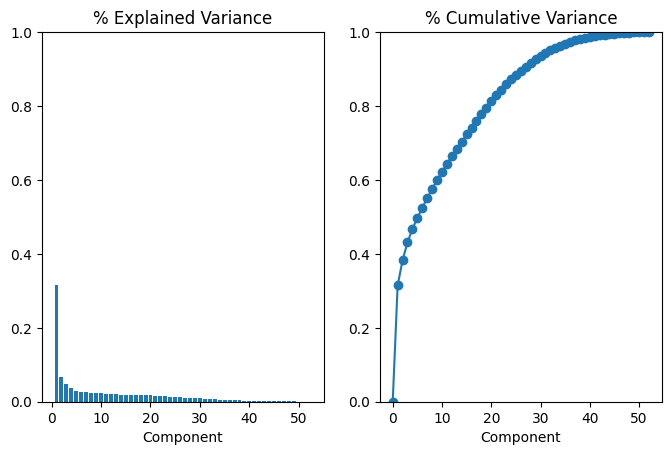

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

# Assuming you have already performed PCA and stored it in the variable pca
axs = plot_variance(pca)
plt.show()

**Mutual Information Feature Selection**

we will explore the use of Mutual Information (MI) as a metric for feature selection for our further model.

Mutual information describes relationships in terms of uncertainty. The MI between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

MI is similar to correlation, but with the advantage of being able to detect any kind of relationship, not just linear ones. Moreover, it is easy to use and interpret, computationally efficient, and theoretically well-founded, and also resistant to overfitting.

So, we will apply MI to our dataset and demonstrate how it can be used to identify the most informative predictors and eliminate the redundant ones, which helps to reduce overfitting and improve the generalization performance of the model. Overall, throughout this notebook, you will gain a better understanding of how MI can be used as a powerful metric for feature selection and its potential to improve the accuracy of our predictions.

In [ ]:
import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif

In [ ]:
# Specify the path
df = pd.read_csv("/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags_lexical_word2vec.csv")
df

,Year,Month,Day,Hour,Day_of_week,From,Subject,X-Origin,Body,sentiment_score_compound,...,Bcc,Sender-Type,Unique-Mails-From-Sender,Contains-Reply-Forwards,Label,Subject_lemma,Body_lemma,Body_pos_frequency,Body_lexical_complexity,Body_word2vec_features
0,2000,11,16,17,3,msagel@home.com,Status,Arnold-J,Status John: I'm not really sure what happened...,0.9616,...,,0,0.003281,0,0,Status,Status John : I 'm not really sure what happen...,"{'NNP': 9, ':': 1, 'PRP': 10, 'VBP': 8, 'RB': ...",0.923077,[ 0.71445566 -2.3261511 1.2993109 1.448487...
1,2000,12,8,13,4,slafontaine@globalp.com,re:summer inverses,Arnold-J,re:summer inverses i suck-hope youve made more...,0.5940,...,,0,0.000729,0,0,re : summer inverse,re : summer inverse i suck-hope youve made mor...,"{'NN': 15, ':': 1, 'NNS': 3, 'VBP': 5, 'VBD': ...",0.947368,[ 0.95756644 -2.114178 0.8945547 1.367256...
2,2001,5,15,16,1,iceoperations@intcx.com,The WTI Bullet swap contracts,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",-0.3923,...,,0,0.000547,0,0,The WTI Bullet swap contract,"The WTI Bullet swap contract Hi , Following th...","{'DT': 9, 'NNP': 43, 'NN': 26, 'NNS': 10, ',':...",0.775862,[ 0.4515546 -1.7378796 0.4099782 1.249512...
3,2000,12,12,7,1,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,-0.4767,...,,0,0.001641,1,0,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,Fwd : NYTimes.com Article : Suspended Rabbi Qu...,"{'NN': 10, ':': 6, 'JJ': 2, 'VBN': 1, 'NNP': 1...",0.617647,[-1.03076708e+00 -1.98776089e-02 8.55472207e-...
4,2001,5,15,6,1,soblander@carrfut.com,daily charts and matrices as hot links 5/15,Arnold-J,daily charts and matrices as hot links 5/15 Th...,-0.0772,...,,0,0.064163,0,0,daily chart and matrix a hot link 5/15,daily chart and matrix a hot link 5/15 The inf...,"{'JJ': 14, 'NNS': 17, 'CC': 11, 'IN': 23, 'CD'...",0.877143,[ 0.4489542 -2.57727 1.3087538 1.816294...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433069,2001,9,21,18,4,bobbie.campbell@enron.com,Review Board Books w/Rebecca\n C./BillB/DaveG/...,Buy-R,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,0.0000,...,,1,0.001276,0,0,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,Review Board Books w/Rebecca C./BillB/DaveG/Mi...,"{'NNP': 12, 'VBD': 1, 'WRB': 2, ':': 2, ',': 2...",0.942308,[ 0.29830086 -0.19684805 0.08153074 -0.267179...
433070,2001,9,4,15,1,sharron.westbrook@enron.com,Audit Committee Materials meeting,Buy-R,Audit Committee Materials meeting Two meetings...,0.0000,...,"dortha.gray@enron.com, k..heathman@enron.com, ...",1,0.008385,0,0,Audit Committee Materials meeting,Audit Committee Materials meeting Two meeting ...,"{'NNP': 21, 'VBG': 1, 'CD': 6, 'NNS': 3, 'VBP'...",0.818116,[ 0.31306246 -1.7426066 0.68086064 0.965420...
433071,2001,11,5,9,0,ted.murphy@enron.com,Credit Story,Buy-R,"Credit Story Rick/Bill/David, Generally, we ha...",0.9758,...,,1,0.011666,0,0,Credit Story,"Credit Story Rick/Bill/David , Generally , we ...","{'NNP': 14, ',': 14, 'PRP': 22, 'VBP': 17, 'VB...",0.896825,[ 0.89823025 -3.3463628 1.566664 2.430928...
433072,2001,10,17,23,2,cassandra.schultz@enron.com,Commodity Group Limit Issue,Buy-R,Commodity Group Limit Issue In addition to the...,0.9658,...,"frank.hayden@enron.com, ted.murphy@enron.com",1,0.012213,0,0,Commodity Group Limit Issue,Commodity Group Limit Issue In addition to the...,"{'NNP': 123, 'IN': 57, 'NN': 61, 'TO': 12, 'DT...",0.902439,[ 4.9536127e-01 -2.7233346e+00 1.1807437e+00 ...


In [ ]:
# Read the data and append the Id
def read_data(path):
    df = pd.read_csv(path)
    df['Id'] = path.split("/")[-1].split(".")[0]
    return df

# Specify the path
df = pd.read_csv("/content/drive/MyDrive/SMU TMLP/enron_clean_reduced_temp_POStags_lexical_word2vec.csv")

# Read and process the specified CSV file
df = read_data(csv_path)

# Display the processed DataFrame
df

OSError: [Errno 28] No space left on device

In [ ]:
display(df)

In [ ]:
# # display(floats)
# # temp.to_csv(file_path + 'test.csv', index=False)

# # for col in ['Subject', 'Body']:
# for col in ['Subject']:
#     temp[col] = df[col].apply(typo_ratio)

# display(temp)

# temp.to_csv(file_path + 'test.csv', index=False)
# display(temp.head(20))
display(temp)

,Subject,Body
0,0.166667,0.028716
1,0.000000,0.000000
2,0.172414,0.074792
3,0.149254,0.076923
4,0.000000,0.052726
...,...,...
433069,0.229885,0.201058
433070,0.090909,0.089744
433071,0.166667,0.028217
433072,0.148148,0.064918


In [ ]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
from nltk.parse import CoreNLPParser
import numpy as np

# assuming 'text' is your column with text data
df['tokens'] = df['text'].apply(word_tokenize)

# Frequency of POS tags
df['pos_tags'] = df['tokens'].apply(nltk.pos_tag)
df['pos_freq'] = df['pos_tags'].apply(lambda x: nltk.FreqDist(tag for (word, tag) in x))

# Frequency of Discourse markers
discourse_markers = set(['also', 'although', 'and', 'but', 'or', 'so', 'because', 'if', 'unless', 'while'])
df['discourse_markers_freq'] = df['tokens'].apply(lambda x: len([word for word in x if word.lower() in discourse_markers]))

# Min-max scaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['pos_freq', 'discourse_markers_freq']]), columns=['pos_freq_scaled', 'discourse_markers_freq_scaled'])

# Median syntactic complexity of sentence and depth of parse tree
# Note: You need to have Stanford CoreNLP server running to use CoreNLPParser
parser = CoreNLPParser(url='http://localhost:9000')
df['parse_tree'] = df['text'].apply(lambda x: next(parser.raw_parse(x)))
df['tree_depth'] = df['parse_tree'].apply(lambda x: x.height())
df['syntactic_complexity'] = df['tree_depth'].median()

# Median lexical complexity of sentence
df['lexical_complexity'] = df['tokens'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
df['lexical_complexity_median'] = df['lexical_complexity'].median()

# Type-token ratio (TTR)
df['TTR'] = df['tokens'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)

### Text Data Preprocessing (Non Fraud)

In this preprocessing pipeline, we will perform several steps to clean and prepare text data for analysis or modeling. Each step is aimed at removing noise and irrelevant information from the text, making it suitable for further processing. Here are the details of each step:

- Decontracted: Expand contracted words like "can't" to "cannot", "won't" to "will not", etc.
- Remove Numbers: Eliminate numerical digits from the text.
- Remove HTML: Strip HTML tags from the text, if present.
- Remove URL: Remove any URLs or hyperlinks from the text.
- Remove Punctuations: Exclude punctuation marks such as commas, periods, exclamation marks, etc.
- Remove Patterns: Delete any specific patterns or regular expressions from the text.
- Remove Stopwords: Eliminate common stopwords (e.g., "the", "is", "and") from the text.
- After applying these preprocessing steps, the text data will be cleaned and ready for further analysis, such as text mining, sentiment analysis, or topic modeling.

In [ ]:
# # Filter the dataframe for fraud emails (label = 1)
# fraud_df = dataframe[dataframe['Label'] == 1]

# # Display the first few rows of the fraud dataframe
# fraud_df.head(10)

# Filter the dataframe for fraud emails (label = 1)
non_fraud_df = dataframe[dataframe['Label'] == 0]

# Display the first few rows of the non fraud dataframe
non_fraud_df.head(10)

,Folder-Name,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Origin,Body,Cc,Bcc,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards,Label
0,arnold-j,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,"""Mark Sagel"" <msagel@home.com>","""John Arnold"" <jarnold@enron.com>",,,Arnold-J,Status John: I'm not really sure what happened...,,,FALSE,External,18,FALSE,FALSE,0.0
1,arnold-j,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,slafontaine@globalp.com,John.Arnold@enron.com,,,Arnold-J,re:summer inverses i suck-hope youve made more...,,,FALSE,External,4,TRUE,FALSE,0.0
2,arnold-j,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,ICE Operations <ICEOperations@intcx.com>,"**ICEHELPDESK <**ICEHELPDESK@intcx.com>, **Int...",,,Arnold-J,"The WTI Bullet swap contracts Hi, Following th...",,,FALSE,External,3,TRUE,FALSE,0.0
3,arnold-j,"Mon, 11 Dec 2000 23:52:00 -0800 (PST)",klarnold@flash.net,john.arnold@enron.com,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Karen Arnold <klarnold@flash.net>,john.arnold@enron.com,,,Arnold-J,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,,,FALSE,External,9,FALSE,TRUE,0.0
4,arnold-j,"Mon, 14 May 2001 23:59:00 -0700 (PDT)",soblander@carrfut.com,soblander@carrfut.com,daily charts and matrices as hot links 5/15,SOblander@carrfut.com,soblander@carrfut.com,,,Arnold-J,daily charts and matrices as hot links 5/15 Th...,,,FALSE,External,352,FALSE,FALSE,0.0
5,arnold-j,"Fri, 10 Nov 2000 05:57:00 -0800 (PST)",alan_batt@oxy.com,john.arnold@enron.com,RE: Resume,<Alan_Batt@oxy.com>,John.Arnold@enron.com,,,Arnold-J,"RE: Resume John, Thanks for the email and the ...",,,FALSE,External,1,TRUE,TRUE,0.0
6,arnold-j,"Wed, 29 Nov 2000 08:11:00 -0800 (PST)",brian.m.corbman@bofasecurities.com,john.arnold@enron.com,Wrong address,"""Corbman, Brian M."" <Brian.M.Corbman@bofasecur...","""John Arnold (E-mail)"" <john.arnold@enron.com>",,,Arnold-J,"Wrong address John, I think I have the wrong e...",,,FALSE,External,1,TRUE,FALSE,0.0
7,arnold-j,"Mon, 14 May 2001 06:50:00 -0700 (PDT)",michael.gapinski@ubspainewebber.com,john.arnold@enron.com,Additional offerings to round out your portfolio,"""Gapinski, Michael"" <michael.gapinski@ubspaine...","""Arnold John (E-mail)"" <john.arnold@enron.com>",,,Arnold-J,Additional offerings to round out your portfol...,,,FALSE,External,2,TRUE,FALSE,0.0
8,arnold-j,"Thu, 7 Dec 2000 01:27:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,slafontaine@globalp.com,John.Arnold@enron.com,,,Arnold-J,they are crazy but mite have to scale in which...,,,FALSE,External,4,TRUE,FALSE,0.0
9,arnold-j,"Tue, 28 Nov 2000 08:29:00 -0800 (PST)",jenwhite7@zdnetonebox.com,john.arnold@enron.com,more about you,"""Jennifer White"" <jenwhite7@zdnetonebox.com>",john.arnold@enron.com,,,Arnold-J,more about you A little bird told me about thi...,,,FALSE,External,2,TRUE,FALSE,0.0


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def decontracted(text):
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'cause", " because", text)
    text = re.sub(r"won\'t", " will not", text)
    return text

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_patterns(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def preprocess_text(text):
    if isinstance(text, str):  # Check if input is a string
        text = decontracted(text)
        text = remove_numbers(text)
        text = remove_html(text)
        text = remove_url(text)
        text = remove_punctuations(text)
        text = remove_patterns(text)
        text = remove_stopwords(text)
        return text
    else:
        return ''  # Return an empty string if input is not a string

# Apply preprocessing to the 'Body' column
non_fraud_df['non_fraud_body'] = non_fraud_df['Body'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-53-57ed9403a38b>:35: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-53-57ed9403a38b>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_fraud_df['non_fraud_body'] = non_fraud_df['Body'].apply(preprocess_text)


### Text Data Preprocessing (Fraud)

In this preprocessing pipeline, we will perform several steps to clean and prepare text data for analysis or modeling. Each step is aimed at removing noise and irrelevant information from the text, making it suitable for further processing. Here are the details of each step:

- Decontracted: Expand contracted words like "can't" to "cannot", "won't" to "will not", etc.
- Remove Numbers: Eliminate numerical digits from the text.
- Remove HTML: Strip HTML tags from the text, if present.
- Remove URL: Remove any URLs or hyperlinks from the text.
- Remove Punctuations: Exclude punctuation marks such as commas, periods, exclamation marks, etc.
- Remove Patterns: Delete any specific patterns or regular expressions from the text.
- Remove Stopwords: Eliminate common stopwords (e.g., "the", "is", "and") from the text.
- After applying these preprocessing steps, the text data will be cleaned and ready for further analysis, such as text mining, sentiment analysis, or topic modeling.

In [ ]:
def decontracted(text):
    # Decontracted
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # Decontracted
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'cause", " because", text)
    text = re.sub(r"won\'t", " will not", text)
    return text

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_patterns(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def preprocess_text(text):
    if isinstance(text, str):  # Check if input is a string
        text = decontracted(text)
        text = remove_numbers(text)
        text = remove_html(text)
        text = remove_url(text)
        text = remove_punctuations(text)
        text = remove_patterns(text)
        text = remove_stopwords(text)
        return text
    else:
        return ''  # Return an empty string if input is not a string

# Apply preprocessing to the 'Body' column
fraud_df['fraud_body'] = fraud_df['Body'].apply(preprocess_text)

<ipython-input-54-b0b539dcc7e1>:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-54-b0b539dcc7e1>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['fraud_body'] = fraud_df['Body'].apply(preprocess_text)


## Word Cloud SpaCy (Non-Fraud)

In [ ]:
# To use the 'wordcloud' library, you need to install it first.
# sing Python's package manager, pip.
# Open a command prompt or terminal and run the following command:
# pip install wordcloud
# Or conda install -c https://conda.anaconda.org/conda-forge wordcloud

# Import the wordcloud library
import warnings
import matplotlib.pyplot as plt
from wordcloud import WordCloud

warnings.simplefilter("ignore", DeprecationWarning)

# Join the different processed titles together.
string_non_fraud = ','.join(list(non_fraud_df['non_fraud_body'].values))

# Create a WordCloud object
wordcloud_non_fraud = WordCloud(background_color= "white",
                      max_words= 300,
                      contour_width= 15,
                      contour_color= 'steelblue',

                      # Specify the words to remove
                      stopwords={"IMAGE"}
                     )

# Generate a word cloud
wordcloud_non_fraud.generate(string_non_fraud)

# Visualize the word cloud
wordcloud_non_fraud.to_image()

plt.figure(figsize= (15, 15), dpi= 1200)
plt.imshow(wordcloud_non_fraud, interpolation= "bilinear")
plt.axis("off")

plt.show()

## Word Cloud SpaCy (Fraud)

In [ ]:
# To use the 'wordcloud' library, you need to install it first.
# sing Python's package manager, pip.
# Open a command prompt or terminal and run the following command:
# pip install wordcloud
# Or conda install -c https://conda.anaconda.org/conda-forge wordcloud

# Import the wordcloud library
import warnings
import matplotlib.pyplot as plt
from wordcloud import WordCloud

warnings.simplefilter("ignore", DeprecationWarning)

# Join the different processed titles together.
string_fraud = ','.join(list(fraud_df['fraud_body'].values))

# Create a WordCloud object
wordcloud_fraud = WordCloud(background_color= "white",
                      max_words= 300,
                      contour_width= 15,
                      contour_color= 'steelblue',

                      # Specify the words to remove
                      stopwords={"IMAGE", "I MAKE", "MAKE"}
                     )

# Generate a word cloud
wordcloud_fraud.generate(string_fraud)

# Visualize the word cloud
wordcloud_fraud.to_image()

plt.figure(figsize= (10, 10), dpi= 1200)
plt.imshow(wordcloud_fraud, interpolation= "bilinear")
plt.axis("off")

plt.show()

#### Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

## LDA Modelling Analysis (Non Fraud)

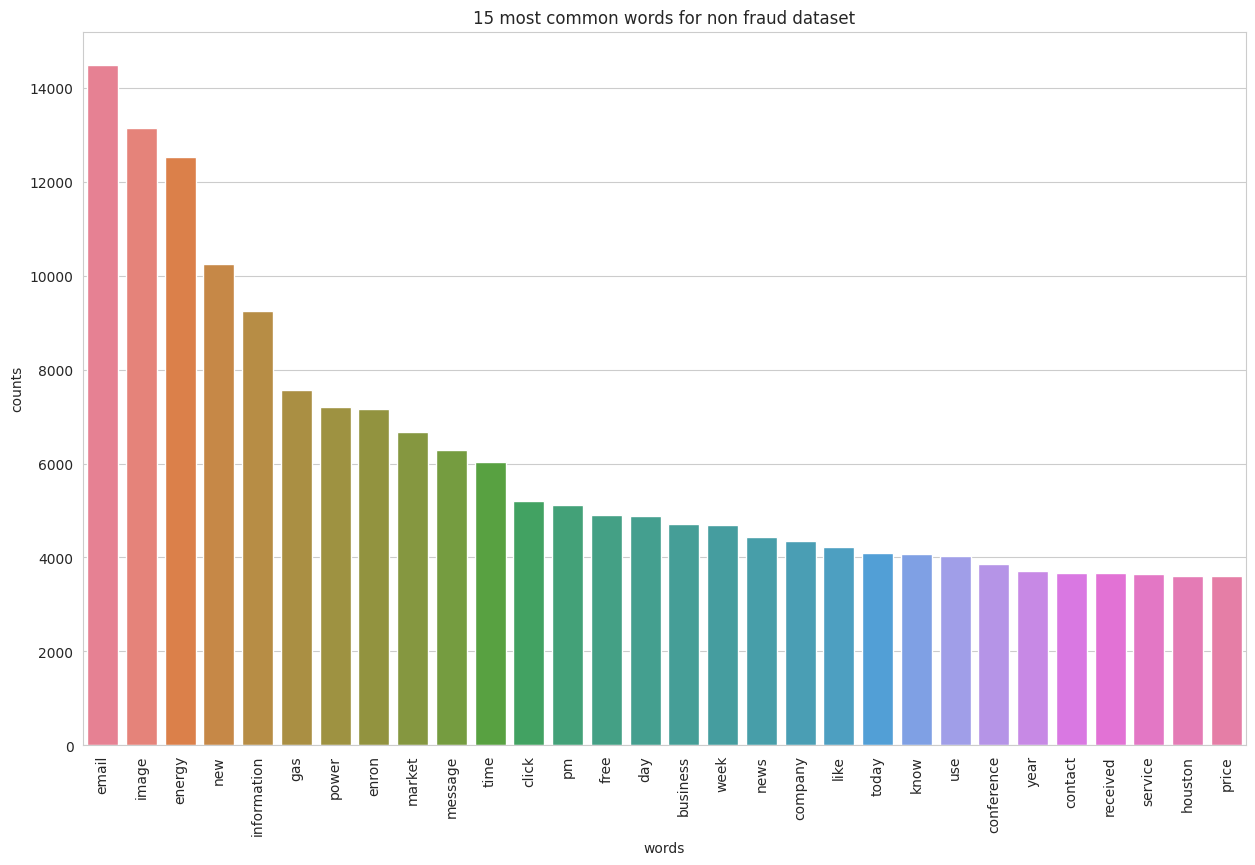

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Helper function
def plot_10_most_common_words(count_data_non_fraud, count_vectorizer_non_fraud):
    import matplotlib.pyplot as plt
    words = count_vectorizer_non_fraud.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data_non_fraud:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='15 most common words for non fraud dataset')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer_non_fraud = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data_non_fraud = count_vectorizer_non_fraud.fit_transform(non_fraud_df['non_fraud_body'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data_non_fraud, count_vectorizer_non_fraud)

## LDA Modelling Analysis (Non Fraud)

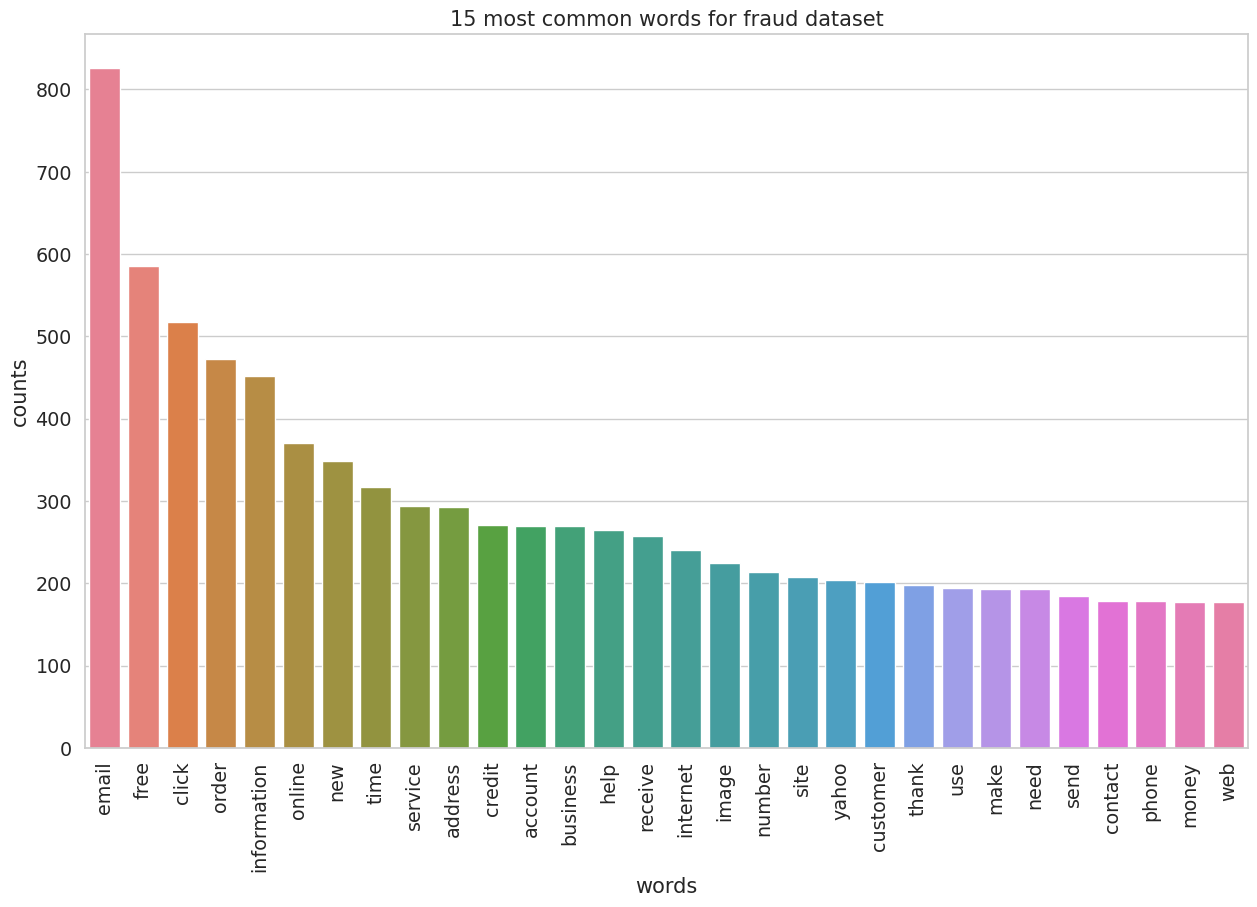

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Helper function
def plot_10_most_common_words(count_data_fraud, count_vectorizer_fraud):
    import matplotlib.pyplot as plt
    words = count_vectorizer_fraud.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data_fraud:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='15 most common words for fraud dataset')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer_fraud = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data_fraud = count_vectorizer_fraud.fit_transform(fraud_df['fraud_body'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data_fraud, count_vectorizer_fraud)

## LDA model tranining (Non Fraud)

To keep things simple, we will only tweak the number of topic parameters.

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model_non_fraud, count_vectorizer_non_fraud, n_top_words_non_fraud):
    words = count_vectorizer_non_fraud.get_feature_names_out()
    for topic_idx, topic in enumerate(model_non_fraud.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words_non_fraud - 1:-1]]))

# Tweak the two parameters below (use int values below 15)
number_topics = 12
number_words = 25

# Create and fit the LDA model
lda_non_fraud = LDA(n_components=number_topics)
lda_non_fraud.fit(count_data_non_fraud)

# Print the topics found by the LDA model
print("Topics found via LDA non fraud:")
print_topics(lda_non_fraud, count_vectorizer_non_fraud, number_words)

Topics found via LDA non fraud:

Topic #0:
enron know thanks vince let time email like forward hope work regards look best thank need pm houston john send make message week dear think

Topic #1:
image pm story oil news energy et price new houston click wine caracas venezuela club bureau petroleumworld live williams email oct showtimes change opec events

Topic #2:
energy new risk management conference business information email market technology industry company research markets group companies trading program contact th forward services financial options like

Topic #3:
network world new market buy eps today na company storage information email service newsletter price security shares linux software services management strong subscription product focus

Topic #4:
email information message order data intended thank enron address received fax use recipient copy number contact attached confidential phone delete sender questions time communication error

Topic #5:
gas energy power natural

## LDA model tranining (Fraud)

To keep things simple, we will only tweak the number of topic parameters.

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model_fraud, count_vectorizer_fraud, n_top_words_fraud):
    words = count_vectorizer_fraud.get_feature_names_out()
    for topic_idx, topic in enumerate(model_fraud.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words_fraud - 1:-1]]))

# Tweak the two parameters below (use int values below 15)
number_topics = 8
number_words = 16

# Create and fit the LDA model
lda_fraud = LDA(n_components=number_topics)
lda_fraud.fit(count_data_fraud)

# Print the topics found by the LDA model
print("Topics found via LDA fraud:")
print_topics(lda_fraud, count_vectorizer_fraud, number_words)

Topics found via LDA fraud:

Topic #0:
email credit free address information order phone receive debt click business help money time card account

Topic #1:
normal order support child customer gift holiday arial color fontsize textdecoration time pt email fontstyle day

Topic #2:
dvd online free copy click wizard edgar site software movie service using movies web email password

Topic #3:
image free email information click receive secure financial id new aid time site account netellercom message

Topic #4:
information click free email message send save vacation password services new legal tv use rates descrambler

Topic #5:
order email business service new click shipment shipped items number use dear days windows help customer

Topic #6:
yahoo account email new etrade internet sales bank address cigar bancware information image online department free

Topic #7:
click free new family digital image service today subscription email tree special available time dear ameritrade


### Analyzing our LDA model (Non-Fraud)

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

Before runnnig code below, first you need to:
pip install pyLDAvis

And then perhaps: pip install --upgrade scikit-learn pyLDAvis

In [ ]:
%%time
import os
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

import pyLDAvis.lda_model
import pickle


# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath_non_fraud = os.path.join('./ldavis_prepared_non_fraud_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared_non_fraud = pyLDAvis.lda_model.prepare(lda_non_fraud, count_data_non_fraud, count_vectorizer_non_fraud)

    with open(LDAvis_data_filepath_non_fraud, 'wb') as f:
        pickle.dump(LDAvis_prepared_non_fraud, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath_non_fraud, 'rb') as f:
    LDAvis_prepared_non_fraud = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared_non_fraud, './ldavis_prepared_non_fraud_'+ str(number_topics) +'.html')

LDAvis_prepared_non_fraud

CPU times: user 6.37 s, sys: 2.49 s, total: 8.87 s
Wall time: 15.8 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.052134  0.157886       1        1  15.443196
2      0.052730  0.125481       2        1  15.403099
7      0.098129  0.019163       3        1  13.176305
10    -0.063260  0.162482       4        1  11.443616
1      0.135142  0.013422       5        1   6.965801
0     -0.032678 -0.109972       6        1   6.903953
3      0.073132  0.108580       7        1   6.604016
9      0.113362 -0.167350       8        1   5.937766
4     -0.137117  0.006531       9        1   5.167813
8      0.088304 -0.199886      10        1   5.133325
6     -0.324399 -0.041891      11        1   4.692805
11    -0.055478 -0.074445      12        1   3.128304, topic_info=              Term          Freq         Total Category  logprob  loglift
30558        image  12594.000000  12594.000000  Default  30.0000  30.0000
19785        email  13866.000000  13866.000000  Default  29.0000  29.0000
25490          gas   7298.000000   7298.000000  Default  28.0000  28.0000
50235           pm   4895.000000   4895.000000  Default  27.0000  27.0000
40828      message   5993.000000   5993.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
65413        texas    243.698685   1742.215246  Topic12  -5.6064   1.4977
65473           th    262.762223   3249.840381  Topic12  -5.5310   0.9496
31688  information    297.638653   8934.849411  Topic12  -5.4064   0.0628
4634     available    219.060968   3195.179827  Topic12  -5.7129   0.7846
20527        enron    221.710580   6890.975471  Topic12  -5.7009   0.0281

[990 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
121        1  0.994188      abilene
310        3  0.986683  accessories
368        1  0.075831      account
368        2  0.036208      account
368        3  0.530817      account
...      ...       ...          ...
73182     12  0.013306         year
73420      9  0.015671          ypo
73420     12  0.976801          ypo
73424     12  0.981625       ypoers
73660      1  0.984139         ziff

[3768 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 11, 2, 1, 4, 10, 5, 9, 7, 12])

### Analyzing our LDA model (Fraud)

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

Before runnnig code below, first you need to:
pip install pyLDAvis

And then perhaps: pip install --upgrade scikit-learn pyLDAvis

In [ ]:
%%time
import os
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

import pyLDAvis.lda_model
import pickle


# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath_fraud = os.path.join('./ldavis_prepared_fraud_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared_fraud = pyLDAvis.lda_model.prepare(lda_fraud, count_data_fraud, count_vectorizer_fraud)

    with open(LDAvis_data_filepath_fraud, 'wb') as f:
        pickle.dump(LDAvis_prepared_fraud, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath_fraud, 'rb') as f:
    LDAvis_prepared_fraud = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared_fraud, './ldavis_prepared_fraud_'+ str(number_topics) +'.html')

LDAvis_prepared_fraud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 421 ms, sys: 29.4 ms, total: 451 ms
Wall time: 2.24 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.015391 -0.031725       1        1  28.352573
1     -0.219779  0.056896       2        1  13.034508
5     -0.065038  0.050379       3        1  12.712405
2      0.035156 -0.161562       4        1  12.321461
4      0.017986 -0.042798       5        1  10.044105
3      0.056716 -0.011861       6        1   9.078773
6      0.150779  0.151507       7        1   8.854730
7      0.039572 -0.010836       8        1   5.601447, topic_info=         Term        Freq       Total Category  logprob  loglift
8315    yahoo  174.000000  174.000000  Default  30.0000  30.0000
2248      dvd  152.000000  152.000000  Default  29.0000  29.0000
5090   normal  126.000000  126.000000  Default  28.0000  28.0000
48    account  239.000000  239.000000  Default  27.0000  27.0000
3634    image  193.000000  193.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
48    account   12.244973  239.492783   Topic8  -5.7023  -0.0913
5497  payment   10.763104   94.894433   Topic8  -5.8313   0.7055
6294   remove   10.791711  126.991363   Topic8  -5.8286   0.4168
5190    offer   10.770969  155.413751   Topic8  -5.8306   0.2129
5249   online   10.641538  330.769879   Topic8  -5.8427  -0.5545

[563 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
16        2  0.950862              absent
27        1  0.840337              accept
27        3  0.048019              accept
27        6  0.072029              accept
27        8  0.048019              accept
...     ...       ...                 ...
8326      3  0.078028                 yes
8326      5  0.585213                 yes
8326      8  0.039014                 yes
8359      3  0.989920       zanybrainycom
8360      3  0.877644  zanybrainycomwhere

[1222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 3, 5, 4, 7, 8])

### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this post addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### Sources:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf


In [ ]:
LDAvis_prepared_non_fraud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.052134  0.157886       1        1  15.443196
2      0.052730  0.125481       2        1  15.403099
7      0.098129  0.019163       3        1  13.176305
10    -0.063260  0.162482       4        1  11.443616
1      0.135142  0.013422       5        1   6.965801
0     -0.032678 -0.109972       6        1   6.903953
3      0.073132  0.108580       7        1   6.604016
9      0.113362 -0.167350       8        1   5.937766
4     -0.137117  0.006531       9        1   5.167813
8      0.088304 -0.199886      10        1   5.133325
6     -0.324399 -0.041891      11        1   4.692805
11    -0.055478 -0.074445      12        1   3.128304, topic_info=              Term          Freq         Total Category  logprob  loglift
30558        image  12594.000000  12594.000000  Default  30.0000  30.0000
19785        email  13866.000000  13866.000000  Default  29.0000  29.0000
25490          gas   7298.000000   7298.000000  Default  28.0000  28.0000
50235           pm   4895.000000   4895.000000  Default  27.0000  27.0000
40828      message   5993.000000   5993.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
65413        texas    243.698685   1742.215246  Topic12  -5.6064   1.4977
65473           th    262.762223   3249.840381  Topic12  -5.5310   0.9496
31688  information    297.638653   8934.849411  Topic12  -5.4064   0.0628
4634     available    219.060968   3195.179827  Topic12  -5.7129   0.7846
20527        enron    221.710580   6890.975471  Topic12  -5.7009   0.0281

[990 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
121        1  0.994188      abilene
310        3  0.986683  accessories
368        1  0.075831      account
368        2  0.036208      account
368        3  0.530817      account
...      ...       ...          ...
73182     12  0.013306         year
73420      9  0.015671          ypo
73420     12  0.976801          ypo
73424     12  0.981625       ypoers
73660      1  0.984139         ziff

[3768 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 11, 2, 1, 4, 10, 5, 9, 7, 12])

In [ ]:
LDAvis_prepared_fraud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.015391 -0.031725       1        1  28.352573
1     -0.219779  0.056896       2        1  13.034508
5     -0.065038  0.050379       3        1  12.712405
2      0.035156 -0.161562       4        1  12.321461
4      0.017986 -0.042798       5        1  10.044105
3      0.056716 -0.011861       6        1   9.078773
6      0.150779  0.151507       7        1   8.854730
7      0.039572 -0.010836       8        1   5.601447, topic_info=         Term        Freq       Total Category  logprob  loglift
8315    yahoo  174.000000  174.000000  Default  30.0000  30.0000
2248      dvd  152.000000  152.000000  Default  29.0000  29.0000
5090   normal  126.000000  126.000000  Default  28.0000  28.0000
48    account  239.000000  239.000000  Default  27.0000  27.0000
3634    image  193.000000  193.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
48    account   12.244973  239.492783   Topic8  -5.7023  -0.0913
5497  payment   10.763104   94.894433   Topic8  -5.8313   0.7055
6294   remove   10.791711  126.991363   Topic8  -5.8286   0.4168
5190    offer   10.770969  155.413751   Topic8  -5.8306   0.2129
5249   online   10.641538  330.769879   Topic8  -5.8427  -0.5545

[563 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
16        2  0.950862              absent
27        1  0.840337              accept
27        3  0.048019              accept
27        6  0.072029              accept
27        8  0.048019              accept
...     ...       ...                 ...
8326      3  0.078028                 yes
8326      5  0.585213                 yes
8326      8  0.039014                 yes
8359      3  0.989920       zanybrainycom
8360      3  0.877644  zanybrainycomwhere

[1222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 3, 5, 4, 7, 8])